In [2]:
# modules to import 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
# this to set the plot styles 
sns.set_context('paper', font_scale = 1.5, rc = {"lines.linewidth": 1.5})
sns.set_style('ticks', {'axes.grid': False, 
                        'grid.linestyle': '', 
                        'font.family':'sans-serif', 
                        'font.sans-serif':'Myriad Pro',
                        'text.color': '0',
                        'xtick.color': '0',
                        'ytick.color': '0'
                           })

from Bio import Seq, SeqIO
from Bio.Seq import Seq
from Bio.Alphabet import generic_dna
from Bio.SeqRecord import SeqRecord
from Bio.SeqFeature import FeatureLocation, CompoundLocation
import networkx as nx
from itertools import islice
import re
import random

# import sklearn modules 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, roc_auc_score
from sklearn.metrics import matthews_corrcoef as mcc
from scipy.spatial.distance import hamming
from sklearn.metrics import pairwise_distances

# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [3]:
def random_seq(seq_length):
    """
    Function that generates a random nucleic_acid sequence of length seq_length.
    Assumes a standard DNA alphabet.
    
    Inputs:
    seq_length: int 
    """
    s = ''.join(random.choice('ATCG') for _ in range(seq_length))
    return s

def turn_switch_to_toehold(switch, rbs = 'AACAGAGGAGA', start_codon = 'ATG'):
    """
    Function that turns a 30nt switch into a complete toehold
    
    Inputs:
    switch: str
    rbs: str
    start_codon: str
    """
    stem1 = Seq(switch[24:30]).reverse_complement().__str__()
    stem2 = Seq(switch[12:21]).reverse_complement().__str__()
    toehold =  switch + rbs + stem1 + start_codon + stem2

    return toehold 

def generate_and_filter_toeholds(seq_length, num_toeholds):
    """
    Function that randomly generates and filters toeholds according to design constraints.
    
    Inputs:
    seq_length: int
    num_toeholds: int
    """
    
    # generates a set of random DNA sequences 
    random_switches = []
    for i in range(int(num_toeholds)):
        s = random_seq(seq_length = seq_length)
        random_switches.append(s)
    
    # turn these switches into toeholds
    rbs = 'AACAGAGGAGA'
    start_codon = 'ATG'
    random_toeholds = [turn_switch_to_toehold(switch = p, rbs = rbs, start_codon = start_codon) for p in random_switches]
    
    # remove all toeholds where there are start codons before the intended one starting at position 47
    no_start = [p for p in random_toeholds if p.index(start_codon) == 47]
    # remove any toeholds that have in-frame stop codons 
    filtered_seqs = [p for p in no_start if len(Seq(p[47:]).translate(to_stop = True)) == 4]
    
    return filtered_seqs

def generate_fixednum_toeholds(seq_length, num_toeholds):
    """
    This function generates a fixed number of random toeholds
    
    Inputs:
    seq_length: int
    num_toeholds: int
    """
    # empty list of toeholds
    kept_seqs = []
    # start with none
    l = 0
    thresh = int(num_toeholds)*2
    while (l <= thresh):
        filt_seqs = []
        filt_seqs = generate_and_filter_toeholds(seq_length = seq_length, num_toeholds = num_toeholds)
        kept_seqs.extend(filt_seqs)
        l += len(kept_seqs)
        
    # if more sequences were generated than needed, randomly sample these
    sampled_seqs = random.sample(kept_seqs, int(num_toeholds))
        
    return sampled_seqs

def compute_ham_dist(s1, s2):
    """
    This function computes the Hamming distance between two DNA strings. 
    Strings have to be the same length. 
    
    Inputs:
    s1: str
    s2: str
    """
    if len(s1) != len(s2):
        raise ValueError("DNA sequences are not of the same length")
    else:
        return sum(1 for (a, b) in zip(s1, s2) if a != b)
    
class One_Hot_Encoder:
    """
    The One_Hot_Encoder class provides functions to encode a string over a
    given alphabet into an integer matrix of shape (len(string), len(alphabet))
    where each row represents a position in the string and each column
    represents a character from the alphabet. Each row has exactly one 1 at the
    matching alphabet character and consists of 0s otherwise.
    """

    def __init__(self, alphabet):
        """ Initialize the object with an alphabet.
        
        Parameters
        ----------
        alphabet : str
            The alphabet that will be used for encoding/decoding (e.g. "ACGT").
        """
        self.alphabet = alphabet
        self.table = {symbol: i for i, symbol in enumerate(alphabet)}
        self.table_rev = {v: k for k, v in self.table.items()}
    
    def encode(self, sequence):
        """ Encode a sequence into a one-hot integer matrix.
        
        The sequence should only contain characters from the alphabet provided to __init__.
        Parameters
        ----------
        sequence : str
            The sequence that should be encoded.
        Returns
        -------
        one_hot: numpy.ndarray
            A numpy array with shape (len(sequence), len(alphabet)).
        """
        one_hot = np.zeros((len(sequence), len(self.table)), np.uint8)
        one_hot[np.arange(len(sequence)), np.fromiter(map(self.table.__getitem__, sequence), np.uint32)] = 1
        return one_hot

    def decode(self, one_hot):
        """ Decode a one-hot integer matrix into the original sequence.
        Parameters
        ----------
        one_hot : numpy.ndarray
            A one-hot matrix (e.g. as created by the encode function).
        Returns
        -------
        sequence: str
            The sequence that is represented by the one-hot matrix.
        """
        return ''.join(map(self.table_rev.__getitem__, np.argmax(one_hot, axis=1)))

def ohe_dna(sequence):
    """
    Function that One Hot Encodes a DNA sequence into a 1D array.
    Used to calculate pairwise Hamming distance. 
    Assumes alphabet is the standard alphabet of ATCG.
    
    Inputs:
    sequence: str
    """
    alph_letters = 'ATCG'
    ohe = One_Hot_Encoder(alph_letters)
    ohe_seq = np.transpose(ohe.encode(sequence).astype('int')).reshape(-1,) # shape = (num_letters * len_seq, )
    return ohe_seq
    

In [4]:
# generate 4M toeholds starting with switches of lenth 30 nt (takes a long time)
toeholds = []
toeholds = generate_fixednum_toeholds(seq_length = 30, num_toeholds = 4e6)
print('Number of generated toeholds:', len(toeholds))

Number of generated toeholds: 4000000


In [5]:
# convert into a numpy array to calculate pairwise hamming distance 
toehold_array = np.array([ohe_dna(p) for p in toeholds])
print('Toehold 1D array shape:', toehold_array.shape)

Toehold 1D array shape: (4000000, 236)


In [6]:
# compute the pairwise hamming distances between sequences
# this is too memory intensive to compute over 4M sequences, so we will draw random samples of 4K 
def sample_and_compute_pwhd(toehold_array, sample_size, sampling_iters):
    """
    This function computes the pairwise hamming distance on a subsample of a large array
    
    Inputs:
    toehold_array: 1D np array that is one hot encoded of all toeholds
    sample_size: int - size of the sample to be drawn < len(toehold_array)
    sampling_iters: int - number of times to repeat the sampling process.
    """
    # make ids for all the sequences, so that we can randomly sample
    ids = np.linspace(0, toehold_array.shape[0], toehold_array.shape[0]+1).astype('int')
    
    pw_hds = []
    # randomly sample from toehold_array
    for i in range(sampling_iters):
        temp_ids = np.random.choice(ids, size = sample_size, replace = False)
        temp_sample = toehold_array[temp_ids]
        temp_pwhd = pairwise_distances(temp_sample, metric = 'hamming', n_jobs = -1)
        pw_hds.append(temp_pwhd)
    
    return pw_hds

In [7]:
# get a list of pairwise distances 
pws = sample_and_compute_pwhd(toehold_array = toehold_array, sample_size = 5000, sampling_iters = 10)

In [8]:
# extract the lower-triangular matrix since pairwise distances are doubly counted 
lt_dists = [np.tril(d).reshape(-1,) for d in pws]
# iterate to get the non-zero distances in the lower-triangular matrix
lt_nzs = []

for array in lt_dists:
    nz_ids = np.nonzero(array)
    lt_nz = array[nz_ids]
    lt_nzs.append(lt_nz)
    
# reshape into 1D array to plot a histogram
lt_nzs = np.array(lt_nzs).reshape(-1,)

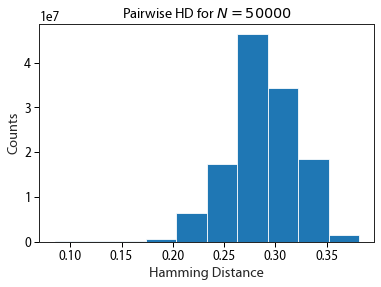

In [9]:
plt.hist(lt_nzs, bins = 10, histtype = 'bar');
plt.xlabel('Hamming Distance');
plt.ylabel('Counts');
plt.title(r'Pairwise HD for $N = 50000$');

In [10]:
# repeat for just the switch portion of the 59 nt toehold
switch_array = np.array([ohe_dna(p[:30]) for p in toeholds])
# get a list of pairwise distances 
switch_pws = sample_and_compute_pwhd(toehold_array = switch_array, 
                                     sample_size = 5000, 
                                     sampling_iters = 10)
# extract the lower-triangular matrix since pairwise distances are doubly counted 
switch_lt_dists = [np.tril(d).reshape(-1,) for d in switch_pws]
# iterate to get the non-zero distances in the lower-triangular matrix
switch_lt_nzs = []

for array in switch_lt_dists:
    nz_ids = np.nonzero(array)
    lt_nz = array[nz_ids]
    switch_lt_nzs.append(lt_nz)
    
# reshape into 1D array to plot a histogram
switch_lt_nzs = np.array(switch_lt_nzs).reshape(-1,)

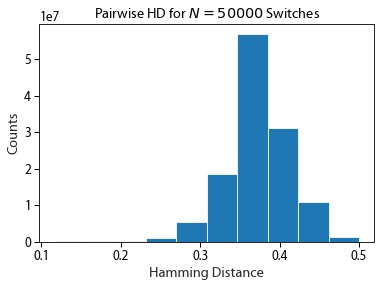

In [11]:
plt.hist(switch_lt_nzs, bins = 10, histtype = 'bar');
plt.xlabel('Hamming Distance');
plt.ylabel('Counts');
plt.title(r'Pairwise HD for $N = 50000$ Switches');

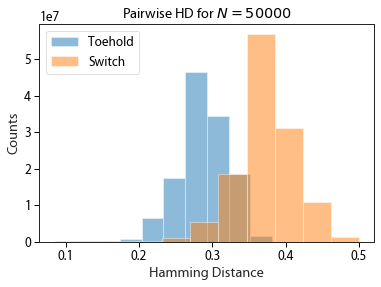

In [12]:
plt.hist(lt_nzs, bins = 10, histtype = 'bar', label = 'Toehold', alpha = 0.5);
plt.hist(switch_lt_nzs, bins = 10, histtype = 'bar', label = 'Switch', alpha = 0.5);
plt.xlabel('Hamming Distance');
plt.ylabel('Counts');
plt.legend()
plt.title(r'Pairwise HD for $N = 50000$');

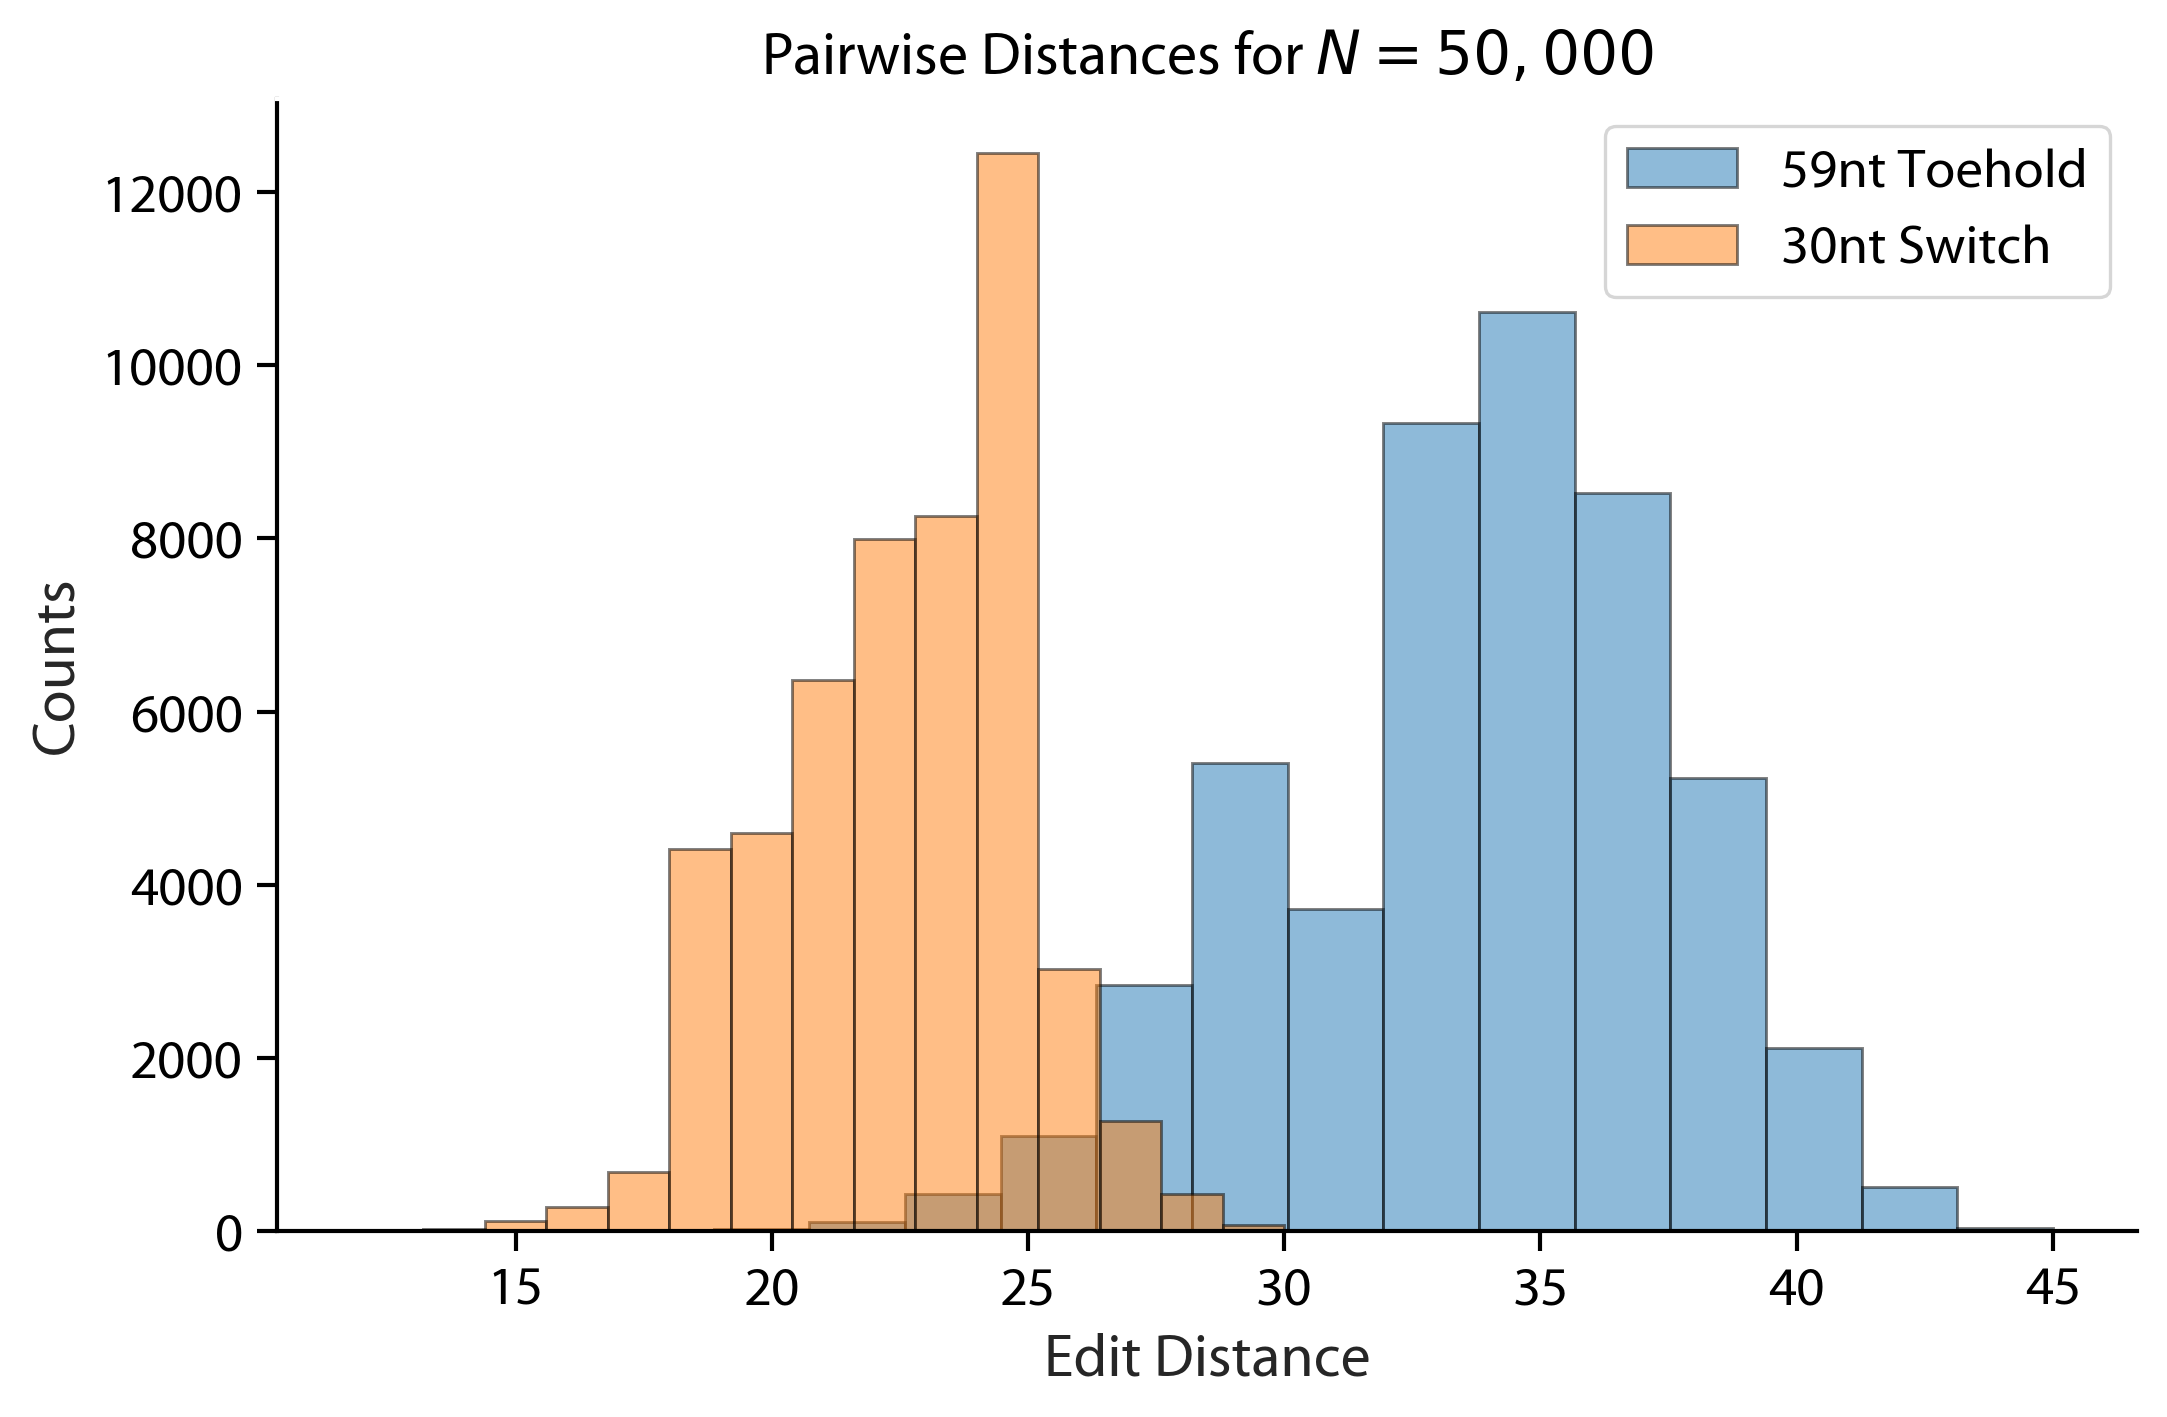

In [35]:
# we have an array of toehold sequence ids
# make ids for all the sequences, so that we can randomly sample
ids = np.linspace(0, toehold_array.shape[0], toehold_array.shape[0]+1).astype('int')
    
s1_ids = np.random.choice(ids, size = 50000, replace = False).astype(int)
s2_ids = np.random.choice(ids, size = 50000, replace = False).astype(int)

s1_seqs = [toeholds[p] for p in s1_ids]
s1_switches = [p[:30] for p in s1_seqs]

s2_seqs = [toeholds[p] for p in s2_ids]
s2_switches = [p[:30] for p in s2_seqs]

edists = [compute_ham_dist(s1, s2) for (s1,s2) in list(zip(s1_seqs, s2_seqs))]
edists_switches = [compute_ham_dist(s1, s2) for (s1,s2) in list(zip(s1_switches, s2_switches))]

fig, ax = plt.subplots(figsize = (8, 5), dpi = 300)
ax.patch.set_facecolor('white')

num_bins = 15

plt.hist(edists, bins = num_bins, histtype = 'bar', label = '59nt Toehold', edgecolor = 'black', alpha = 0.5, linewidth = 0.7);
plt.hist(edists_switches, bins = num_bins, histtype = 'bar', label = '30nt Switch', edgecolor = 'black', alpha = 0.5, linewidth = 0.7);

ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.spines['top'].set_color('white')
ax.spines['right'].set_color('white')

plt.xlabel('Edit Distance');
plt.ylabel('Counts');
plt.legend()
plt.title(r'Pairwise Distances for $N = 50,000$');

#plt.savefig('../../illustrator_files/supp/s12_pairwise_distances.svg')
plt.show()